# Theory
VRP : https://developers.google.com/optimization/routing/vrp \
CVRP : https://developers.google.com/optimization/routing/cvrp#python

In [1]:
%pip install ortools

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import networkx as nx
import numpy as np

from ortools.sat.python import cp_model
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
from random import randint, sample, seed

from scripts.cvrp import TestCVRP
from scripts import graph_osm_loader, utils, clustering

from scripts.graph_filtration.utils import plot_simplex
from scripts.graph_filtration.clustering import dijkstra_neighbourhood, build_knn_graph


print(f'This machine has {os.cpu_count()} cores')


This machine has 32 cores


Text(0.5, 1.0, '723 nodes')

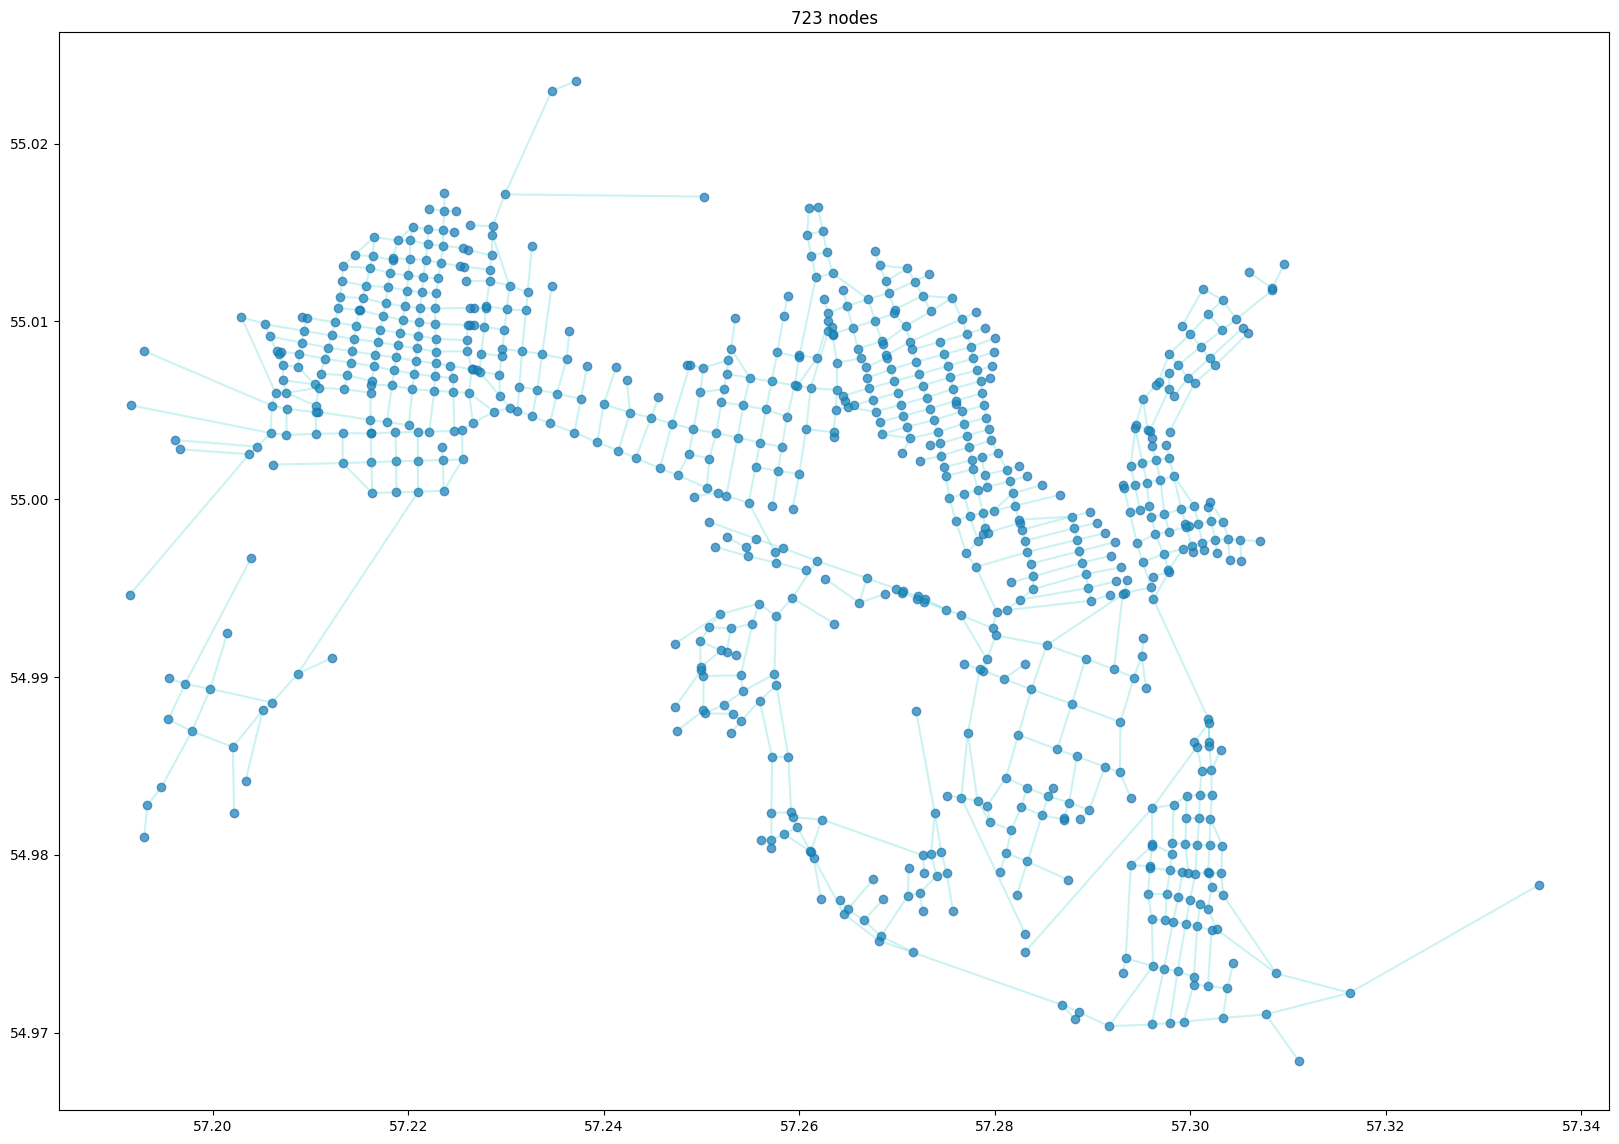

In [3]:
np.random.seed(0)
seed(0)


CITY = 'ASHA'
GRAPH_ID = graph_osm_loader.cities[CITY] # KRG

# примеры id есть в graph_osm_loader.py
G = graph_osm_loader.get_graph(GRAPH_ID) # загрузка графа

pos = {u: [d['x'], d['y']] for u,d in G.nodes(data=True)} 

A = nx.adjacency_matrix(G, weight='length').todense()


K = [
        list(G.nodes), # dim = 0 : vertices
        list(G.edges), # dim = 1 : edges
    ]

plt.figure(figsize=(20, 14))
plot_simplex(pos, K)
plt.title(f'{len(G.nodes)} nodes')

0it [00:00, ?it/s]

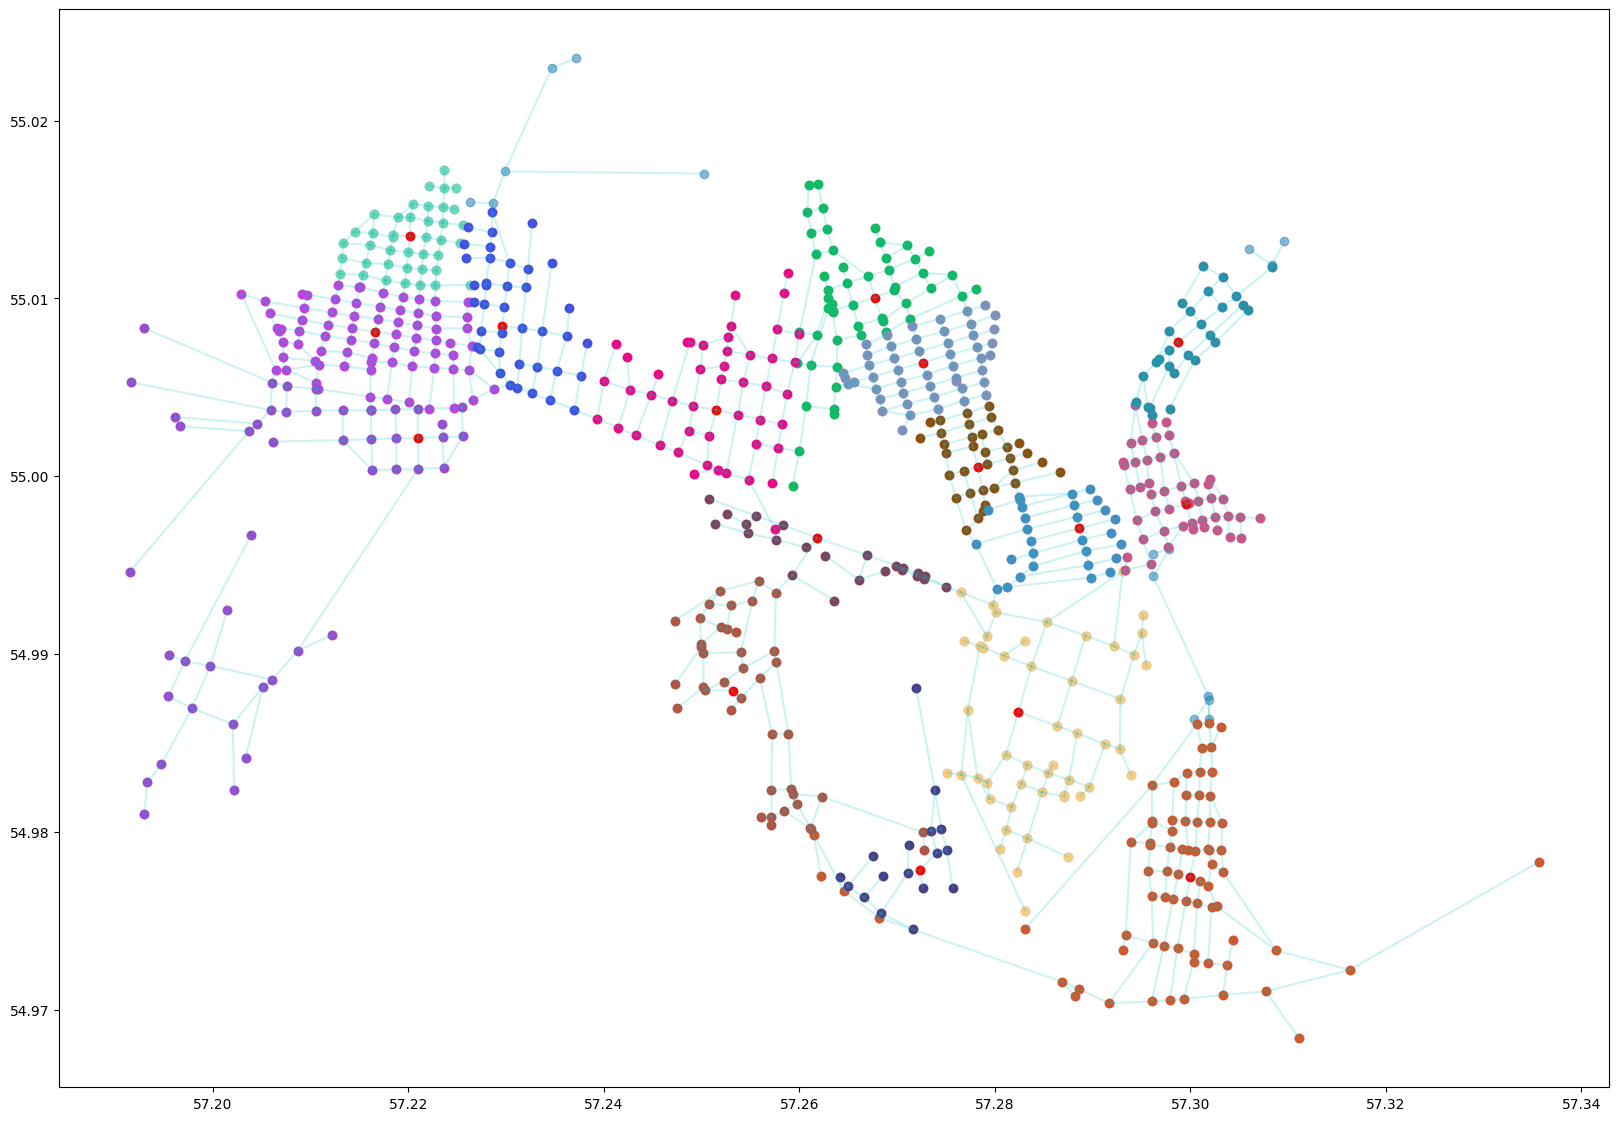

In [4]:
from random import sample
import leidenalg as la

communities = clustering.leiden(G, partition_type=la.CPMVertexPartition, resolution_parameter = 0.3, weights='length', seed=0)
communities = [c for c in communities if len(c) >= 10]

# Set the hubs
hubs = []

for cluster in communities:
    G_cluster = G.subgraph(cluster)
    hubs.append(nx.barycenter(G_cluster, weight='length')[0])

plt.figure(figsize=(20, 14))

plot_simplex(pos, K, alpha=0.5)
for j, cluster in tqdm(enumerate(communities)):
    color = '#%06X' % randint(0, 0xFFFFFF)
    for v in cluster:
        point = pos[v]
        if v in hubs:
            plt.scatter(point[0], point[1], c='red')
        else:
            plt.scatter(point[0], point[1], c=color)

In [5]:
# Max number of delivery points
sample_size = 20
N = sample_size #max([len(c) for c in communities])
# Number of vehicles
P = 4
# max delivery steps
max_steps = int(N / P * 1.5)

print(f'{len(communities)} communities: {[len(c) for c in communities]}')
print(f'N: {N}, max_steps: {max_steps}, max_steps * P = {max_steps * P}')

16 communities: [75, 74, 53, 50, 50, 49, 48, 48, 42, 41, 40, 35, 30, 28, 24, 18]
N: 20, max_steps: 7, max_steps * P = 28


In [6]:
n_jobs = 20
time_limit = 5
cvrp_task = TestCVRP(G, max_steps=max_steps, n_vehicles=P, time_limit=time_limit, weight='length', num_workers=n_jobs)

cvrp_task.generate_demand()
total, results = cvrp_task.test_cluster(communities, hubs, subset_size=sample_size)


  0%|          | 0/16 [00:00<?, ?it/s]

Solution status: FEASIBLE
Solution status: FEASIBLE
Solution status: FEASIBLE
Solution status: FEASIBLE
Solution status: FEASIBLE
Solution status: FEASIBLE
Solution status: FEASIBLE
Solution status: FEASIBLE
Solution status: FEASIBLE
Solution status: FEASIBLE
Solution status: FEASIBLE
Solution status: FEASIBLE
Solution status: FEASIBLE
Solution status: FEASIBLE
Solution status: FEASIBLE
Solution status: FEASIBLE


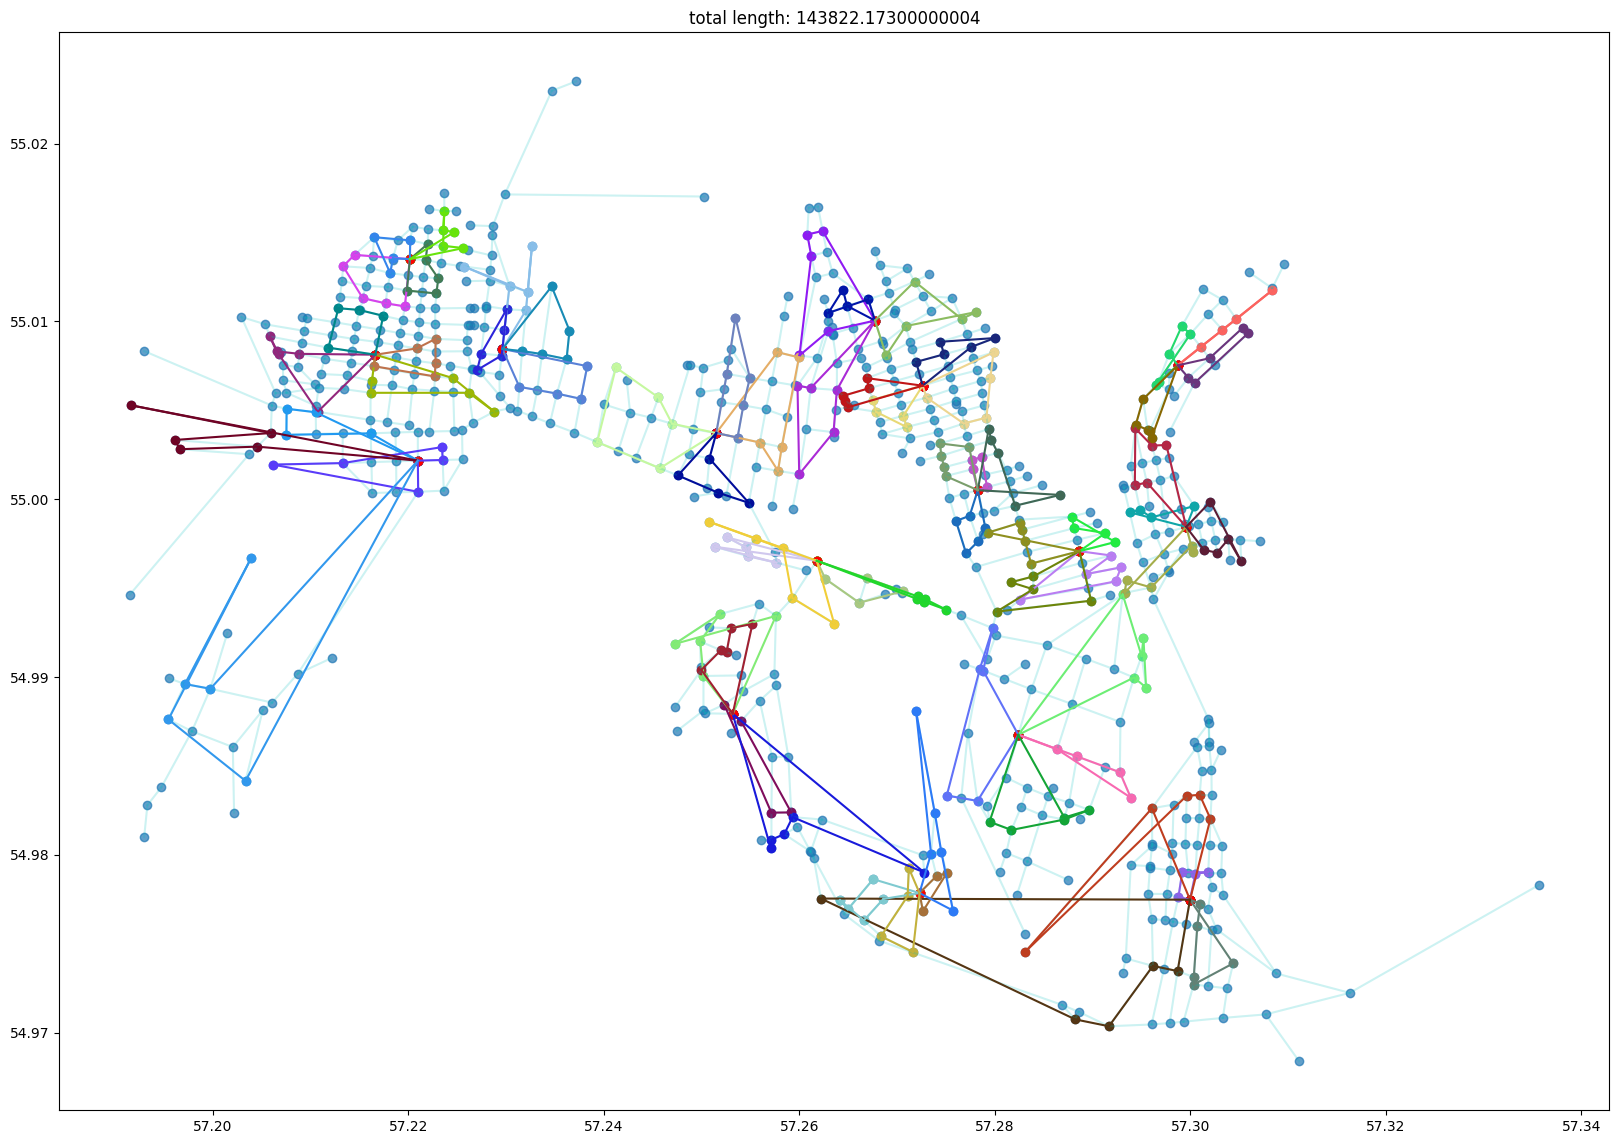

In [7]:
paths = []
for c in results:
    paths += c

plt.figure(figsize=(20, 14))
cvrp_task.plot_routes(paths, total, pos=pos, show=True)